# Fatwa IR & Summarization

With the growth of the Muslim population and the advent of social media, there's an increasing demand for Fatwas, leading to a high-demand, low-supply situation.
This demand peaks during high seasons like Pilgrimage, Umrah, and Ramadan.
Additionally, the emergence of unofficial online platforms for issuing Fatwas has led to concerns regarding the authenticity and reliability of the rulings provided.




# `Step 0:` Install Dependencies


In [ ]:
# %pip install -q -U transformers openai gradio faiss-gpu torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.9

In [ ]:
#system
import os
import logging
import time
# Indexing
import faiss
# gradio
import gradio as gr
# Modeling
import torch
import openai
from transformers import AutoModelForCausalLM, AutoTokenizer, StoppingCriteria, StoppingCriteriaList, TextIteratorStreamer
#Processing
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np
from threading import Thread
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
# Global Variables
MODEL_NAME = "aubmindlab/aragpt2-large"
INDEX_PATH = "/content/faiss_index_file_1.index"
METADATA_PATH = "/content/metadata_1.pkl"
HF_API = ""
CSV_FILE = '/content/1kData.csv'

# `Step 1:` Indexing using **FAISS Embedding**



`1.1` **Load:** First we need to load our data. This is done with Document Loaders.

`1.2` **Split:** Text splitters break large Documents into smaller chunks. This is useful both for indexing data and for passing it in to a model, since large chunks are harder to search over and won't fit in a model's finite context window.

`1.3` **Store:** We need somewhere to store and index our splits, so that they can later be searched over. This is often done using a VectorStore and Embeddings model.






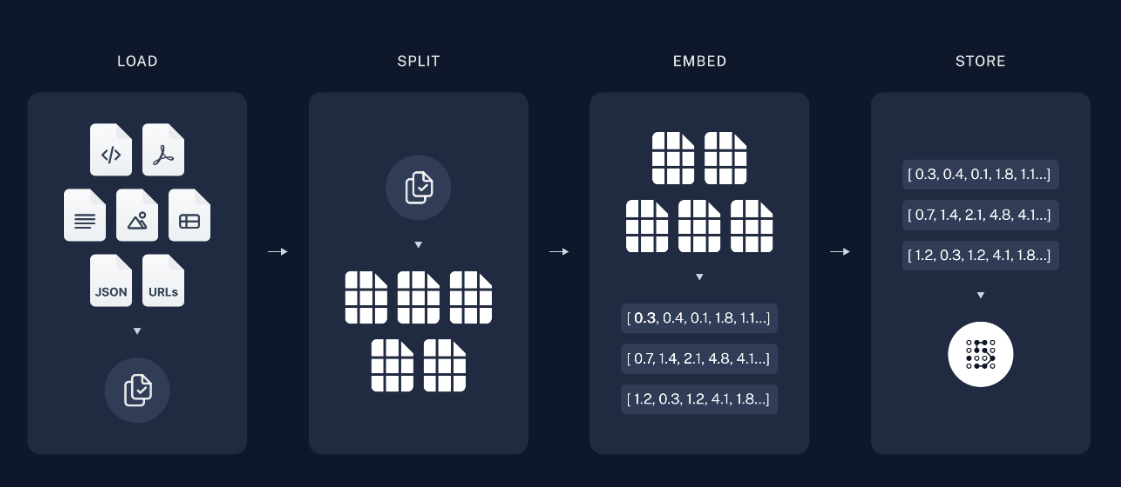

In [ ]:
class FAISSEmbedding:
    def __init__(self, MODEL_NAME, HF_API):
        print("Initializing FAISS embedding class")
        print("Initializing tokenizer ")
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=HF_API, trust_remote_code=True)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Check if the tokenizer has a padding token, if not add one
        if self.tokenizer.pad_token is None:
            self.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

        print("Initializing Model ")
        self.model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, token=HF_API, trust_remote_code=True).to(self.device)

        # Resize model embeddings if new tokens were added
        self.model.resize_token_embeddings(len(self.tokenizer))
        self.index = None
        self.embeddings = None
        self.titles = []
        self.questions = []
        self.answers = []
        self.data = None
        self.MAX_LENGTH = 256
        self.batch_size = 8

    def load_csv_data(self, file_path):
        logging.info(f"Loading data from {file_path}")
        self.data = pd.read_csv(file_path, encoding='utf-8')
        if 'ques' not in self.data.columns or 'ans' not in self.data.columns:
            logging.error("CSV file must contain 'ques' and 'ans' columns")
            raise ValueError("CSV file must contain 'ques' and 'ans' columns")

        # Convert non-string columns to strings
        self.data['ques'] = self.data['ques'].astype(str)
        self.data['ans'] = self.data['ans'].astype(str)
        if 'title' in self.data.columns:
            self.data['title'] = self.data['title'].astype(str)

        # Select first 1k rows
        self.data = self.data[:1000]
        self.data = FAISSEmbedding.clean_data(self.data)

        # Clean data
        self.data['ans'] = self.data['ans'].apply(FAISSEmbedding.remove_text)

        self.questions = self.data['ques'].tolist()
        self.answers = self.data['ans'].tolist()
        if 'title' in self.data.columns:
            self.titles = self.data['title'].tolist()
        logging.info(f"Data loaded successfully, shape: {self.data.shape}")
        logging.info(self.data.head())

    @staticmethod
    def clean_data(data: pd.DataFrame):
        # Remove any rows with missing values
        data = data.dropna()
        # Remove any duplicate rows
        data = data.drop_duplicates()
        return data

    @staticmethod
    def remove_text(text: str):
        string_to_remove = "الحمد لله والصلاة والسلام على رسول الله وعلى آله وصحبه أما بعد:"
        if text.startswith(string_to_remove):
            return text[len(string_to_remove):].strip()
        return text

    def get_embeddings_in_batches(self, texts, batch_size=8, type='titles'):
        logging.info(f"Creating embeddings for the {len(texts)} {type} in batches of {batch_size}")

        embeddings_ls = []
        with tqdm(total=len(texts), desc="Generating Embeddings") as pbar:
            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i + batch_size]
                valid_texts = [text for text in batch_texts if text != '']

                if not valid_texts:
                    pbar.update(len(batch_texts))
                    continue

                inputs = self.tokenizer(valid_texts, return_tensors='pt', padding=True, truncation=True, max_length=self.MAX_LENGTH).to(self.device)
                with torch.no_deep_learning_models(self.device):
                    outputs = self.model(**inputs, output_hidden_states=True)

                hidden_states = outputs.hidden_states[-1]  # Get the last layer's hidden state
                batch_embeddings = hidden_states.mean(dim=1).cpu().numpy()
                embeddings_ls.append(batch_embeddings)
                pbar.update(len(batch_texts))

                # Clear memory
                del inputs, outputs, batch_embeddings
                torch.cuda.empty_cache()

        # Concatenate all batch embeddings into a single numpy array
        embeddings_ls = np.concatenate(embeddings_ls, axis=0)
        logging.info(f"embeddings_ls length: {len(embeddings_ls)}")

        return embeddings_ls

    def create_embeddings(self, batch_size=4):
        title_embeddings = self.get_embeddings_in_batches(self.titles, batch_size, type='titles')
        ques_embeddings = self.get_embeddings_in_batches(self.questions, batch_size, type='questions')
        # ans_embeddings = self.get_embeddings_in_batches(self.answers, batch_size, type='answers')

        # Combine embeddings into a single array
        self.embeddings = np.hstack((title_embeddings, ques_embeddings))
        logging.info(f"Embeddings created, shape: {self.embeddings.shape}")
        return self.embeddings

    def save_embeddings(self, embeddings, file_path):
        np.save(file_path, embeddings)
        logging.info(f"Embeddings saved to {file_path}")

    def build_index(self):
        logging.info("Building FAISS index")
        dimension = self.embeddings.shape[1]
        self.index = faiss.IndexFlatL2(dimension)
        self.index.add(self.embeddings)
        logging.info("FAISS index built")

    def save_index(self, file_path, metadata_path):
        logging.info(f"Saving FAISS index to {file_path}")
        faiss.write_index(self.index, file_path)
        with open(metadata_path, 'wb') as f:
            pickle.dump({'titles': self.titles, 'questions': self.questions, 'answers': self.answers}, f)
        logging.info("FAISS index and metadata saved")

    def load_index(self, file_path, metadata_path):
        logging.info(f"Loading FAISS index from {file_path}")
        self.index = faiss.read_index(file_path)
        with open(metadata_path, 'rb') as f:
            metadata = pickle.load(f)
            self.titles = metadata['titles']
            self.questions = metadata['questions']
            self.answers = metadata['answers']
        logging.info("FAISS index and metadata loaded")
        return self.index


In [ ]:
# # Use the model from the CohereForAI collection
# faiss_embedding = FAISSEmbedding(MODEL_NAME, HF_API)

# # Load data from a CSV file
# start_time = time.time()
# faiss_embedding.load_csv_data(CSV_FILE)
# print(f"Loading data took {time.time() - start_time:.2f} seconds")

# # Create embeddings for the questions
# start_time = time.time()
# out_embeddings = faiss_embedding.create_embeddings()
# print(f"Creating embeddings took {time.time() - start_time:.2f} seconds")

# # Build the FAISS index
# start_time = time.time()
# faiss_embedding.build_index()
# logging.info(f"Building the index took {time.time() - start_time:.2f} seconds")

# # Save the index to a file
# start_time = time.time()
# faiss_embedding.save_index('faiss_index_file.index', 'metadata.pkl')
# logging.info(f"Saving the index took {time.time() - start_time:.2f} seconds")

# # Save the Embeddinga to a file
# start_time = time.time()
# faiss_embedding.save_embeddings(out_embeddings, 'embeddings.npy')
# logging.info(f"Saving the index took {time.time() - start_time:.2f} seconds")


# `Step 2:` Retrieval and generation using **FAISS Embedding**

`2.1` **Retrieve:** Given a user input, relevant splits are retrieved from storage using a Retriever.

`2.2` **Generate:** A ChatModel / LLM produces an answer using a prompt that includes the question and the retrieved data




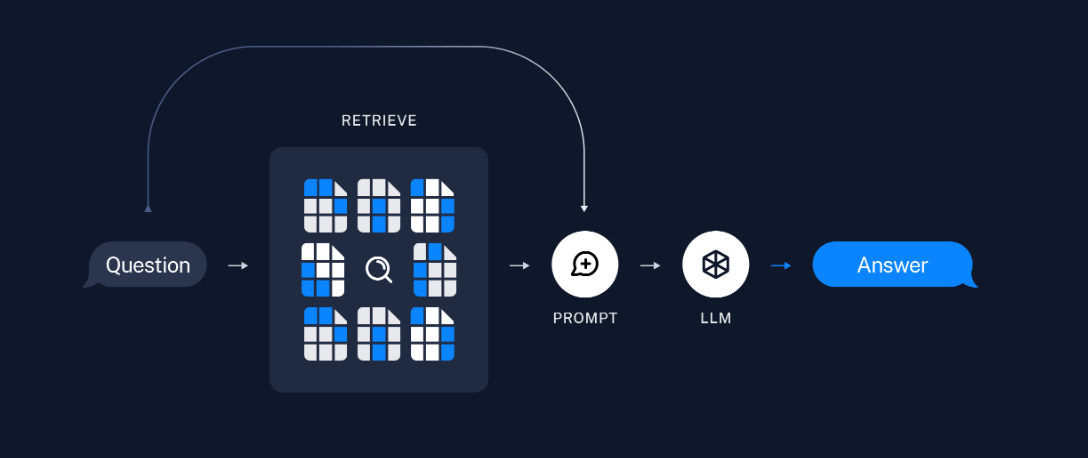

In [ ]:

FAISS_wrapper = FAISSEmbedding(MODEL_NAME, HF_API)

indexer = faiss.read_index(INDEX_PATH)
with open(METADATA_PATH, 'rb') as f:
    metadata = pickle.load(f)
    titles = metadata['titles']
    questions = metadata['questions']
    answers = metadata['answers']


Initializing FAISS embedding class
Initializing tokenizer 


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Initializing Model 


In [ ]:
def FAISSRetriever(query, top_k=5):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Generate the embedding for the query
        inputs = FAISS_wrapper.tokenizer(query, return_tensors='pt', padding=True, truncation=True, max_length=256).to(device)
        with torch.no_grad():
            outputs = FAISS_wrapper.model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1]  # Get the last layer's hidden state
        query_embedding = hidden_states.mean(dim=1).cpu().numpy()

        # Ensure the query vector matches the combined embedding dimensions
        query_vector = np.hstack((query_embedding, query_embedding))

        # Search the index
        distances, indices = indexer.search(query_vector, top_k)
        logging.info(f"Distances shape: {distances.shape}, type: {type(distances)}")
        logging.info(indices)
        most_similar_entries = []
        for i in indices[0]:
            entry = {
                "title": titles[i] if titles else "",
                "question": questions[i],
                "answer": answers[i],
            }
            most_similar_entries.append(entry)
        return most_similar_entries


In [ ]:
FAISSRetriever("ما حكم ترك الصلاه ؟ ", top_k=1 )

[{'title': 'الاستفتاح سنة في الفريضة والنافلة ولا يلزم تاركه شيء',
  'question': 'نبدأ في كل صلاة بدعاء الاستفتاح، فهل نبدأ به الصلوات المسنونة أيضًا -كالشفع والوتر، وباقي السنن المؤكدة-؟ وما حكم من تركه ناسيًا أو متعمدًا؟',
  'answer': 'الحمد لله، والصلاة والسلام على رسول الله، وعلى آله، وصحبه، وبعد:\nفجمهور العلماء على أن الاستفتاح مسنون في الصلاة، وتستوي في ذلك النافلة والفريضة، والأصح أنه لا يلزم تاركه شيء، ولو تركه عمدًا، وبالأحرى إذا كان ناسيًا، إلا أنه لا ينبغي تعمد تركه؛ لما فيه من فوات الأجر الكثير بالعمل اليسير، قال ابن قدامة في المغني: وجملته: أن الاستفتاح من سنن الصلاة، في قول أكثر أهل العلم. اهـ.\nوالله أعلم.'}]

# `Step 3:` Gradio Interface

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [ ]:
from huggingface_hub import InferenceClient

client = InferenceClient("HuggingFaceH4/zephyr-7b-beta", token = HF_API)

def respond(
    message: str,
    history: [[str,str]],
    system_message: str,
    max_tokens: int,
    temperature: float,
    top_p: float,
):
    system_message = "You are an Arabic, muslim knowledgeable religion man. \
    you add greetings and you ask questions like real counsellor. Remember you are helpful and a good listener.\
     You are concise. You response like a human counsellor accurately and correctly.\
       Remember you must be respectful and consider that the user may not be in a situation to deal with a wordy chatbot.\
          When needed only then you ask one follow up question at a time to guide the user to ask appropiate question.\
           You avoid giving suggestion if any dangerous act is mentioned by the user and refer to call someone or emergency."

    messages = [{"role": "system", "content": system_message}]

    for val in history:
        if val[0]:
            messages.append({"role": "user", "content": val[0]})
        if val[1]:
            messages.append({"role": "assistant", "content": val[1]})

    messages.append({"role": "user", "content": message})

    # RAG - Retrieve relevant documents
    retrieved_docs = FAISSRetriever(message, top_k=3 )
    print(retrieved_docs)
    results = [retrieved_docs[i]["answer"] for i in range(len(retrieved_docs))]

    context = "\n".join(results)
    messages.append({"role": "system", "content": "Relevant questions: " + context})

    response = ""
    for message in client.chat_completion(
        messages,
        max_tokens=max_tokens,
        stream=True,
        temperature=temperature,
        top_p=top_p,
    ):
        token = message.choices[0].delta.content
        response += token
        yield response

In [ ]:
demo = gr.Blocks()

with demo:
    gr.Markdown("🧘‍♀️ **Your Assistant**")
    gr.Markdown(
        "‼️Disclaimer: This chatbot is based on  دار الافتاء   "
        "أنا لست مفتي and the use of this chatbot is at your own responsibility.‼️"
    )

    chatbot = gr.ChatInterface(
        respond,
        examples=[
            ["ما هو حكم الصلاه ؟"],
            ["ما هو حكم الزكاه"]

        ],
        title='Your Assistant 👩‍⚕️'
    )

if __name__ == "__main__":
    demo.launch(debug = True)

/usr/local/lib/python3.10/dist-packages/gradio/utils.py:1001: UserWarning: Expected 6 arguments for function <function respond at 0x7913b5c213f0>, received 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/utils.py:1005: UserWarning: Expected at least 6 arguments for function <function respond at 0x7913b5c213f0>, received 2.
  warnings.warn(


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://ee35bd5a2dea97c9ad.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ee35bd5a2dea97c9ad.gradio.live
